## Data Used is processed_data.csv

Fault 1 is characterized by sudden spikes in signals, which are recreated using inuction method and htn they are labbeled as faulty, since 4 aults are to be discovered we add another set of columns F1, F2, F3, F4 which is 0 when normal and 1 when fualty

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy
import scipy.stats as stats
import random


In [2]:
data_path = r'G:\GlitchDetect\supervised_learning_non_seq\generated_data\100_sensors.csv'

## INDUCE SPIKES FOR F1

In [10]:

df = pd.read_csv(data_path)
columns = df.columns[1:]  # skip time column

# Initialize fault_label column if not already there
if 'fault_label' not in df.columns:
    df['fault_label'] = 0  

# --------- SPIKES ----------
num_spikes = 5000
for _ in range(num_spikes):
    # pick only rows that are fault-free
    fault_free_rows = df.index[df['fault_label'] == 0]
    if len(fault_free_rows) == 0:
        break  # stop if no clean rows left
    row = np.random.choice(fault_free_rows)
    col = np.random.choice(columns)

    spike = np.random.uniform(20, 40)
    df.at[row, col] += spike
    df.at[row, 'fault_label'] = 1

# --------- FLATLINES ----------
num_flatlines = 2000
segment_length = 10
for _ in range(num_flatlines):
    fault_free_rows = df.index[(df['fault_label'] == 0)].to_numpy()
    # filter so whole segment is fault-free
    fault_free_rows = fault_free_rows[fault_free_rows <= len(df) - segment_length]
    if len(fault_free_rows) == 0:
        break

    start = np.random.choice(fault_free_rows)
    col = np.random.choice(columns)

    # check the segment is all clean
    if (df.loc[start:start+segment_length, 'fault_label'] != 0).any():
        continue  

    value = df.at[start, col]
    df.loc[start:start+segment_length, col] = value
    df.loc[start:start+segment_length, 'fault_label'] = 2

# --------- LEAKS ----------
num_leaks = 20000
leak_length = 15
for _ in range(num_leaks):
    fault_free_rows = df.index[(df['fault_label'] == 0)].to_numpy()
    fault_free_rows = fault_free_rows[fault_free_rows <= len(df) - leak_length]
    if len(fault_free_rows) == 0:
        break

    start = np.random.choice(fault_free_rows)
    col = np.random.choice(columns)

    if (df.loc[start:start+leak_length, 'fault_label'] != 0).any():
        continue  

    for i in range(leak_length):
        df.at[start + i, col] -= i * np.random.uniform(0.1, 0.5)
        df.at[start + i, 'fault_label'] = 3


In [11]:
df.to_csv(r'G:\GlitchDetect\supervised_learning_non_seq\generated_data\100_hr_fault.csv', index=False)


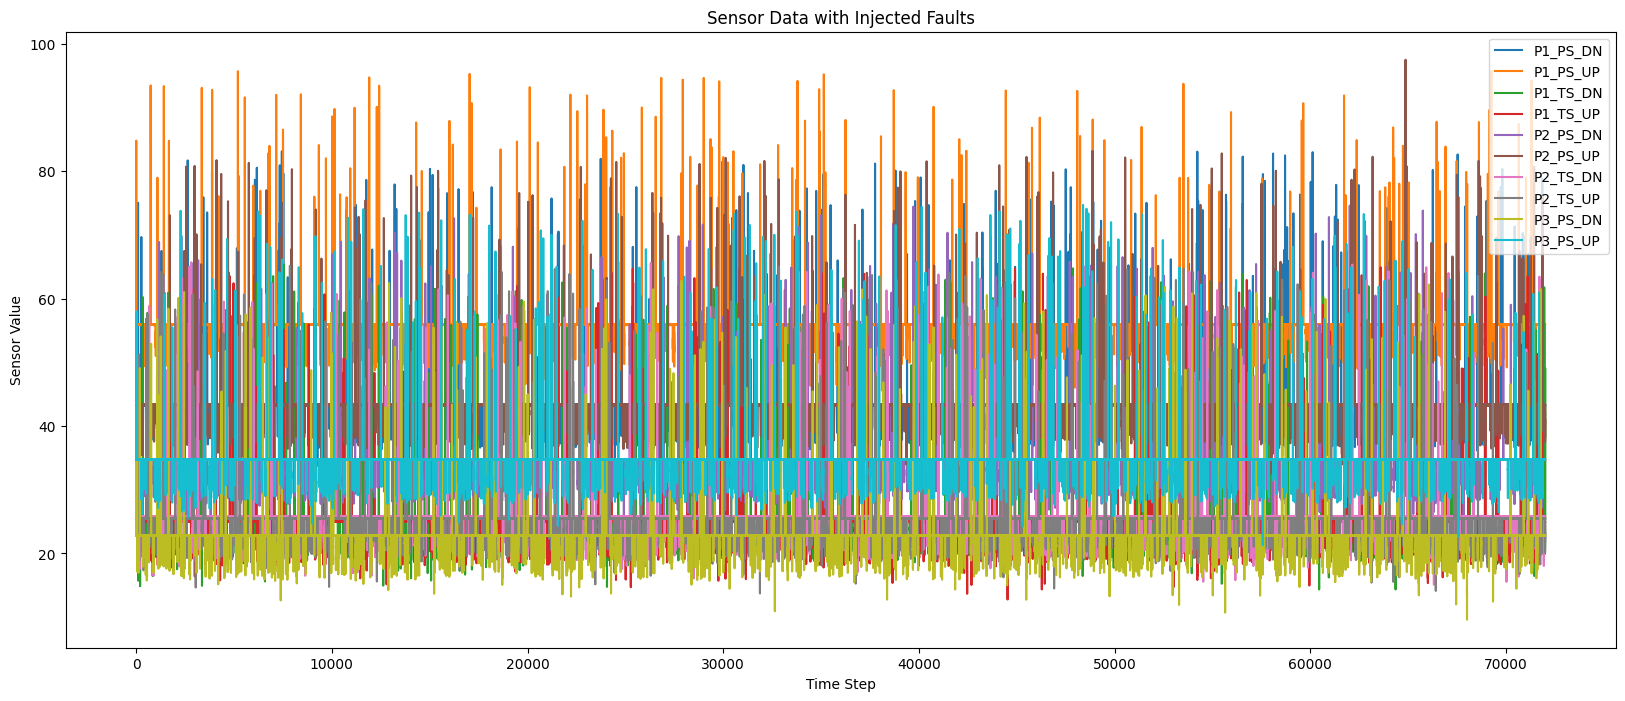

c:\Users\adith\miniconda3\envs\emerson\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


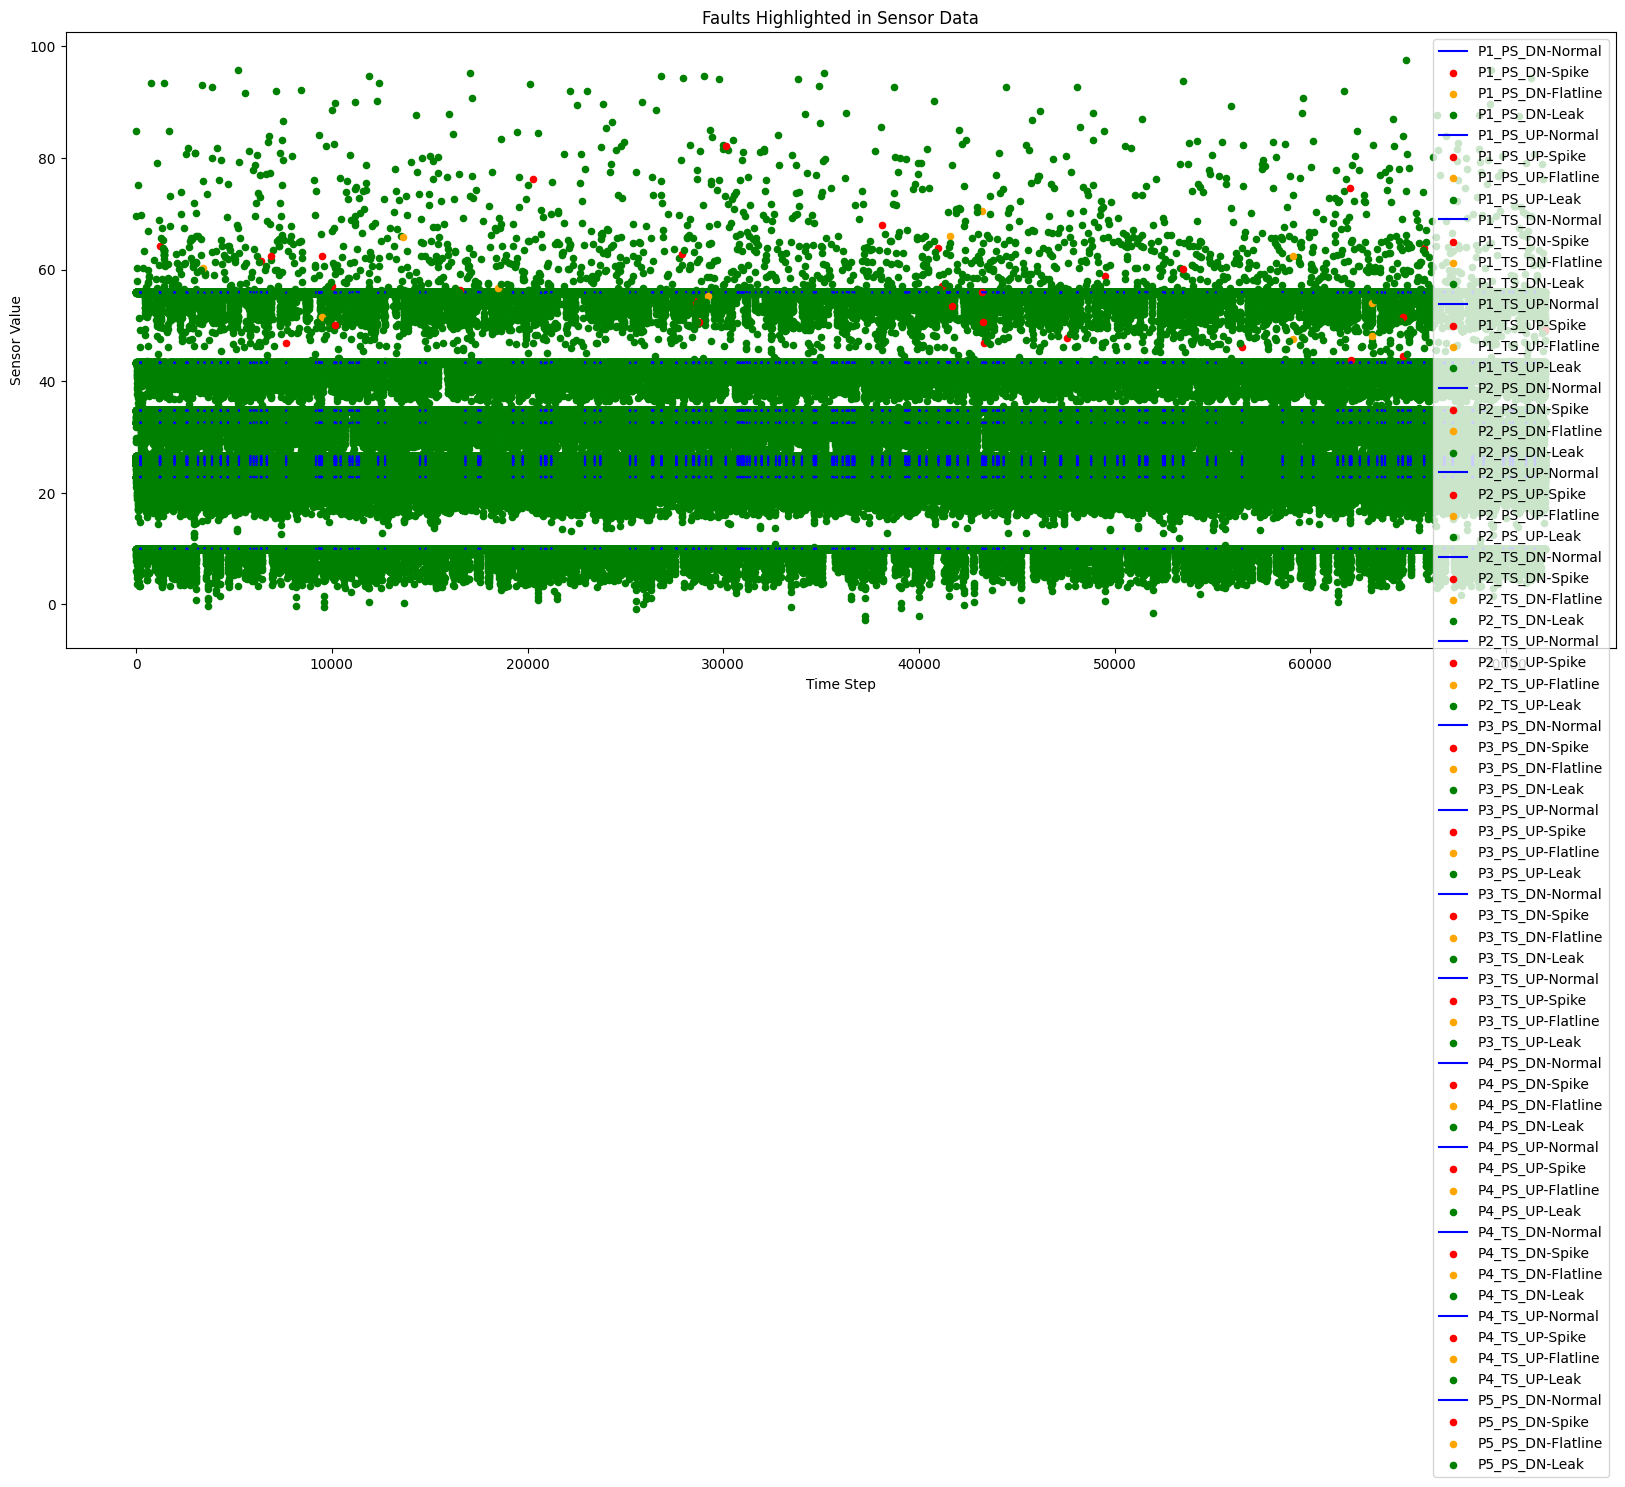

In [8]:
plt.figure(figsize=(20, 8))
for col in columns[:10]:  # plot first 5 sensors for clarity
    plt.plot(df[col], label=col)
plt.title('Sensor Data with Injected Faults')
plt.xlabel('Time Step')
plt.ylabel('Sensor Value')
plt.legend()
plt.show()

# Optional: highlight faults in plots
plt.figure(figsize=(20, 8))
for col in columns[:17]:
    normal = df[col].where(df['fault_label']==0)
    spike = df[col].where(df['fault_label']==1)
    flatline = df[col].where(df['fault_label']==2)
    leak = df[col].where(df['fault_label']==3)
    
    plt.plot(normal, label=f'{col}-Normal', color='blue')
    plt.scatter(spike.index, spike, label=f'{col}-Spike', color='red', s=20)
    plt.scatter(flatline.index, flatline, label=f'{col}-Flatline', color='orange', s=20)
    plt.scatter(leak.index, leak, label=f'{col}-Leak', color='green', s=20)

plt.title('Faults Highlighted in Sensor Data')
plt.xlabel('Time Step')
plt.ylabel('Sensor Value')
plt.legend()
plt.show()

In [9]:
# calculate correaltion between PS and TS of same pipeline of same side
for i in range(1, 9):
    corr = df[f'P{i}_PS_UP'].corr(df[f'P{i}_TS_UP'])
    print(f'Correlation between P{i} PS UP and TS UP: {corr}')
    corr = df[f'P{i}_PS_DN'].corr(df[f'P{i}_TS_DN'])
    print(f'Correlation between P{i} PS DN and TS DN: {corr}')
    
print()
for i in range(1, 8):
    corr = df[f'P{i}_PS_UP'].corr(df[f'P{i+1}_PS_UP'])
    print(f'Correlation between P{i} PS UP and P{i+1} PS UP: {corr}')
    corr = df[f'P{i}_PS_DN'].corr(df[f'P{i+1}_PS_DN'])
    print(f'Correlation between P{i} PS DN and P{i+1} PS DN: {corr}')

print()
for i in range(1, 9):
    corr = df[f'P{i}_TS_UP'].corr(df[f'P{i}_TS_DN'])
    print(f'Correlation between P{i} TS UP and TS DN: {corr}')
    corr = df[f'P{i}_PS_UP'].corr(df[f'P{i}_PS_DN'])
    print(f'Correlation between P{i} PS UP and PS DN: {corr}')

Correlation between P1 PS UP and TS UP: 0.005230092609434998
Correlation between P1 PS DN and TS DN: -0.005097955902815971
Correlation between P2 PS UP and TS UP: -0.002135347765788255
Correlation between P2 PS DN and TS DN: -0.0005988553488311771
Correlation between P3 PS UP and TS UP: 0.0032981804240265304
Correlation between P3 PS DN and TS DN: -0.0008154808379621562
Correlation between P4 PS UP and TS UP: 0.0007412152872928337
Correlation between P4 PS DN and TS DN: -0.0037117069077380496
Correlation between P5 PS UP and TS UP: -0.0031431221977611112
Correlation between P5 PS DN and TS DN: -0.0044780406580113815
Correlation between P6 PS UP and TS UP: 0.0036633388830476067
Correlation between P6 PS DN and TS DN: -0.0009715153488274891
Correlation between P7 PS UP and TS UP: 0.0034631281129930526
Correlation between P7 PS DN and TS DN: 0.0010560125071381265
Correlation between P8 PS UP and TS UP: -0.0021380996239382505
Correlation between P8 PS DN and TS DN: 0.004741906892309438

Co